### SELF PLAY

In [2]:
from tensorflow.keras import models
from   svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
import glob
import os
import pickle
import tensorflow as tf
import chess
import numpy as np
import nbimporter
import chess.svg

from Board_to_NeuralNetwork import board_to_network_input
from Board_to_NeuralNetwork import all_possible_moves
model=tf.keras.models.load_model(r'C:\Users\45819\Downloads\supervised_model__.h5')




def choose_files_with_pattern(max_num=9999, pickles_path=''):
    """
    Finds files with a given file path pattern and returns them in a list.
    Stops after finding the specified maximum number of files.
    """
    files = []
    i = 1
    for file in glob.glob(pickles_path):
        files.append(file)
        if i >= max_num:
            break
        i += 1
    return files

def save_image(board, i, formatted_string):
    """
    Saves an SVG image and PNG image of the chess board at the current state.
    """
    boardsvg = chess.svg.board(board=board)
    outputfile = './supervised_game' + formatted_string + '/match%03d.SVG' % i
    outputpng = './supervised_game' + formatted_string + '/match%03d.png' % i
    with open(outputfile, "w") as f:
        f.write(boardsvg)
    drawing = svg2rlg(outputfile)
    renderPM.drawToFile(drawing, outputpng, dpi=200, fmt="PNG")
    os.remove(outputfile)



class Chess_object():
    def __init__(self):
        """
        Initializes a new chess board object using the chess library.
        Also initializes a variable n_moves to 64.
        """
        self.board = chess.Board()
        # List of all possible chess moves
        self.moves_list = all_possible_moves()
        self.n_moves = len(self.moves_list)
        self.legal_moves = None
        self.legal_moves_string = None
    def find_move_index(self, move):
        """
        Given a move, return its index in the list of all possible moves.
        """
        idx = np.where(self.moves_list == move)
        return idx

    def find_index_move(self, index):
        """
        Given an index, return the corresponding move.
        """
        return self.moves_list[index]

    def printboard(self):
        """
        Print the current state of the chess board.
        """
        print(self.board)

    def setstartingposition(self):
        """
        Set the chess board to the starting position.
        """
        self.board = chess.Board()

    def applymove(self, move_str):
        """
        Apply the move on the chess board and update the turn.
        Also reset the legal_moves variable.
        """
        move = chess.Move.from_uci(move_str)
        board = self.board.copy()
        board.push(move)
        self.legal_moves = None
        self.board = board

    def generatelegalmoves(self):
        """
        Generate a list of legal moves and set it to the legal_moves variable.
        If the legal_moves variable is already set, return it without regenerating it.
        """
        moves = list(self.board.legal_moves)
        self.legal_moves = moves
        self.legal_moves_string = [str(move) for move in self.legal_moves]
        return self.legal_moves

    def getlegalmovesidxs(self):
        """
        Return the indices of the legal moves in the list of all possible moves.
        """
        legal_moves = [str(move) for move in self.board.legal_moves]
        indices = [i for i, x in enumerate(self.moves_list) if x in legal_moves]
        return indices

    def isTerminal(self):
        """
        Determine if the current chess board state is a terminal state.
        Print the outcome of the game.
        Return a tuple (bool, winner) where bool is True if the game is over,
        and winner is the winner of the game ('White'/'Black') or None if the game is a draw.
        """
        winner = None
        self.result = self.board.result()
        print('result', self.result)
        if self.result=='*':
            return False, None 
        elif self.result=='1-0':
            return True, 1
        elif self.result=='0-1':
            return True, -1
        elif self.result=='1/2-1/2':
            return True, 0

    def toNetworkInput(self):
        """
        Converts the current chess board state to a format that can be used as input to a neural network.
        The method uses the split_dims_rami function which is not defined in the code snippet provided.
        """
        x=board_to_network_input(self.board)
        return np.expand_dims(x, axis=0)
    def getmovesprobabilities(self):
        
        x=self.toNetworkInput()
        moves_prob,evaluation=model.predict(x)

        return moves_prob,evaluation


import os
import pickle
import numpy as np


def play_n_games(games=3, save=False):
    """
    Play a number of chess games and save the training data.
    :param games: The number of games to play.
    :param save: Whether to save the training data or not.
    """
    for game in range(games):
        # Initialize board
        b = Chess_object()
        # Set starting position
        b.setstartingposition()
        i = 0
        if save:
            # Define output images folder location
            x = len(choose_files_with_pattern(max_num=9999, pickles_path='./supervised_game*')) + 2
            print('found n games:', x, '\n\n\n\n\n')
            formatted_string = "{:03d}".format(x)
            game_folder = './supervised_game' + formatted_string
            if not os.path.isdir(game_folder):
                os.mkdir(game_folder)
            
        # Initializing placeholders for the saved training data
        positions = []
        best_moves_probs = []
        outcomes = []
        evaluations = []
        
        while True:
            # Transform the board to a neural network-friendly input
            x = b.toNetworkInput()
            # Get the move probabilities and evaluation for all possible moves
            probs, evaluation = b.getmovesprobabilities()
            # Reshape probabilities to (n_moves,) from (n_moves)
            probs = probs.reshape(b.n_moves)
            # Generate all legal moves of the given chess board
            b.generatelegalmoves()
            # Get the indexes of the legal moves
            legal_moves_idx = b.getlegalmovesidxs()
            # Set the probability of illegal moves to zero
            mask = np.zeros_like(probs, dtype=bool)
            mask[legal_moves_idx] = True
            probs[~mask] = 0
            probs /= np.sum(probs)

            # Choose the next move
            # Probabilistic move based on the probabilities
            idx = np.random.choice(len(probs), p=probs)
            # Find the string representation of the best move
            bm = b.find_index_move(idx)
        
            print('%2.2f'%(probs[idx]/np.sum(probs)*100),'%% move probability')
            
            positions.append(x)
            best_moves_probs.append(probs)
            evaluations.append(evaluation)
            print(bm)
            # Make the move!
            b.applymove(bm)
            if save:
                save_image(b.board, i, formatted_string)
            i += 1
            condition, score = b.isTerminal()
            if condition:
                print('game is over', score)
                break
        print('game lasted ', i, ' moves \n\n\n')
        
        # Save the training data
        x = len(choose_files_with_pattern(max_num=9999999, pickles_path='./selfplaydata/positions*')) + 1
        formatted_string = "{:05d}".format(x)
        
        with open("./selfplaydata/positions"+formatted_string, "ab") as f:
            pickle.dump(positions, f)
        with open("./selfplaydata/best_moves_probs"+formatted_string, "ab") as f:
            pickle.dump(best_moves_probs, f)
        with open("./selfplaydata/evaluations"+formatted_string, "ab") as f:
            pickle.dump(evaluations, f)
        print('score:',score)
        for k in range(i):
            outcomes.append(score)
        with open("./selfplaydata/outcomes"+formatted_string,"ab") as f:
            pickle.dump(outcomes,f)
        
        

play_n_games(1,save=False)


    

1/1 [==============================] - 0s 310ms/step
3.97 %% move probability
c2c4
result *
1/1 [==============================] - 0s 17ms/step
20.66 %% move probability
g8f6
result *
1/1 [==============================] - 0s 17ms/step
43.12 %% move probability
g2g3
result *
1/1 [==============================] - 0s 18ms/step
74.88 %% move probability
e7e6
result *
1/1 [==============================] - 0s 18ms/step
100.00 %% move probability
f1g2
result *
1/1 [==============================] - 0s 18ms/step
76.49 %% move probability
c7c5
result *
1/1 [==============================] - 0s 17ms/step
99.05 %% move probability
g1f3
result *
1/1 [==============================] - 0s 17ms/step
99.78 %% move probability
f8e7
result *
1/1 [==============================] - 0s 18ms/step
99.53 %% move probability
e1g1
result *
1/1 [==============================] - 0s 18ms/step
99.84 %% move probability
e8g8
result *
1/1 [==============================] - 0s 18ms/step
99.11 %% move probability
d

1/1 [==============================] - 0s 18ms/step
1.49 %% move probability
h8g8
result *
1/1 [==============================] - 0s 18ms/step
98.57 %% move probability
h4h5
result *
1/1 [==============================] - 0s 19ms/step
92.83 %% move probability
g8g7
result *
1/1 [==============================] - 0s 18ms/step
100.00 %% move probability
h5h6
result *
1/1 [==============================] - 0s 17ms/step
99.99 %% move probability
g7h7
result *
1/1 [==============================] - 0s 18ms/step
97.30 %% move probability
g5f6
result *
1/1 [==============================] - 0s 18ms/step
96.88 %% move probability
h7h6
result *
1/1 [==============================] - 0s 18ms/step
97.04 %% move probability
f6f7
result *
1/1 [==============================] - 0s 18ms/step
98.01 %% move probability
h6g5
result *
1/1 [==============================] - 0s 17ms/step
84.66 %% move probability
f7e7
result *
1/1 [==============================] - 0s 18ms/step
98.22 %% move probability
g5

### RUN MCTS STEP

In [ ]:
possible_moves=all_possible_moves()
model=tf.keras.models.load_model(r'C:\Users\45819\Downloads\supervised_model__.h5')

class TreeNode():
    def __init__(self,board):
        # average winrate of node
        self.M=0
        
        # amounts of wins
        self.W=0
        
        #amount of times this node has been visited
        self.V=0
        
        # Depth away from root
        self.depth=0
        
        # Variation name:
        self.variation=[]
        
        ### Each node should also have probabilities of being visited from previous position to be used for montecarlo
        self.Prior_Probability=0
        
        # Visited moves (at least one simulation has been done for that move)
        self.visitedMovesAndNodes=[]
        
        # Possible moves that have not been expanded
        self.nonVisitedLegalMoves=[]
        
        # the board
        self.board=board
        
        # The root node does not have any parents, for the creation of the children (moves), 
        # For the children upon creation we will modify the self.parent attribute
        self.parent=None
        
        for m in self.board.legal_moves:
            self.nonVisitedLegalMoves.append(m)
    #Is this a leaf node 
    def isMCTSLeafNode(self):
        return len(self.nonVisitedLegalMoves)!=0
    def isTerminalNode(self):
        return len(self.nonVisitedLegalMoves)==0 and len(self.visitedMovesAndNodes)==0

    
def get_network_probabilities(board):
    x=board_to_network_input(board)
    x=np.expand_dims(x, axis=0)
    # Predict move probabilities of the network
    probs,evaluation=model.predict(x)
    probs=probs.reshape(1968)
    legal_moves=[str(move) for move in list(board.legal_moves)]
    legal_moves_idxs = [i for i, x in enumerate(possible_moves) if x in legal_moves]
    mask=np.zeros_like(probs,dtype=bool)
    mask[legal_moves_idxs]=True
    probs[~mask]=0
    probs/=np.sum(probs)
    return probs
    
def Q_PLUS_U(node,parent):

    c_pukt=1
    P=node.Prior_Probability
    U=c_pukt*P*np.sqrt(parent.V)/(1+node.V)
    Q=node.M
    return Q+U



def select(node):
    #If the node is a leaf or a terminal node return the node itself.
    if node.isMCTSLeafNode() or node.isTerminalNode():
        print('selection has reached a leaf node')
        return node
    else:
        maxCUChild= None
        maxCUValue=-1000000

        for move, child in node.visitedMovesAndNodes:
            CUValChild=Q_PLUS_U(child,node)
            if (CUValChild>maxCUValue):
                maxCUChild=child
                maxCUValue=CUValChild
        if (maxCUChild==None):
            raise ValueError("could not identify child with best uct value")
        else:
            return (select(maxCUChild))

def expand(node):
    moveToExpand=node.nonVisitedLegalMoves.pop()
#     print('expanding move: ',moveToExpand)
    board= node.board.copy()
    probs=get_network_probabilities(board)
    
    idx=np.where(str(moveToExpand)==possible_moves)
    print('expanding move: ',str(moveToExpand))
    print('Normalized probability:',probs[idx][0])
    #Push the move on a new copied version of the board
    board.push(moveToExpand)
    childNode=TreeNode(board)
    childNode.parent=node
    childNode.Prior_Probability=probs[idx][0]
    childNode.depth=node.depth+1
    childNode.variation.append(str(moveToExpand))
    node.visitedMovesAndNodes.append((moveToExpand, childNode))
    return childNode
    
def simulate(node):
    board=node.board.copy()
    turn=board.turn
    moves=[]
    i=0
    ## Get the board of the node
    while((board.result()!= "1-0") and (board.result()!= "0-1") and (board.result()!= "1/2-1/2") ):
        
        probs=get_network_probabilities(board)
        idx=np.random.choice(len(probs),p=probs)
        print('MCTS simulation: move chosen:',possible_moves[idx])
        node.variation.append(possible_moves[idx])
        move=chess.Move.from_uci(possible_moves[idx])
        moves.append(move)
        board.push(move)
#         if i<10:
#             print(i+1,' move made:')
#             i+=1
#             print(board)
    payout=0.5
    o=board.result()
    print('moves played:',[str(move) for move in moves])
    if o=="1-0":
        payout=1
        print('white win')
    if o=="0-1":
        payout=0
        print('black win')
    if o=="1/2-1/2":
        payout=0.5
        print('its a draw')
    return payout



def backpropagate(node,payout):
    print('backpropagating a payout of ',payout,'for node with variation:',node.variation,'at depth', node.depth)
    node.M=((node.M*node.V)+payout)/(node.V+1)
    node.V=node.V+1
    node.W=node.W+payout
    print('updated node.M and node.V values:',node.M,node.V)
    if node.parent!=None:
        return backpropagate(node.parent,payout)
    

    
fen=   "r1bqkbnr/pppp1ppp/n7/4p3/2B1P3/5Q2/PPPP1PPP/RNB1K1NR w KQkq - 0 1"



def run_MCTS_step(fen,N_simulations):
    
    # After a while that simulations are running the inference time for the neural network slows down from
    # 20 ms per board up to 1000 ms per board. In order to reduce this slowing down, we are deleting and reloading the 
    # model in memory every time a new game starts in order to save computation time.
    del model
    model=tf.keras.models.load_model(r'C:\Users\45819\Downloads\supervised_model__.h5')

    
    board=chess.Board(fen)
    root=TreeNode(board)

    for i in range(N_simulations):
        print('selection ',i,'is starting:')
        node=select(root)
        #if the selected node is a terminal we cannot expand
        # any child node. in this case, count htis as a win/draw/loss
        if (not node.isTerminalNode()):
    #         print('expansion ',i,'is starting:')
            node=expand(node)
            payout=simulate(node)
            backpropagate(node,payout)
        elif node.isTerminalNode():
            print('damn not terminal')

    #     print('simulation ',i,'is starting:')


    #     print('simulation result: ',payout)
    #     print('backpropagation ',i,'is starting:')


    root.visitedMovesAndNodes.sort(key=lambda x:x[1].M, reverse=True)
    return root
    
# root=run_MCTS_step(fen='8/8/2P5/1K6/8/8/8/k7 w - - 0 1',N_simulations=3)

In [ ]:
### MCTS to NN input

In [ ]:

def softmax(x):
    """Compute the softmax function for an array x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def set_network_probs(board,move):
    idx=np.where(possible_moves==moves)
    probs=np.zeros_like(possible_moves,dtype=np.float32)
    probs[idx]=1.
    # Update the move probabilities.
    return probs        
            
def print_results(root):
    i_w=0
    i_d=0
    i_l=0
    root.visitedMovesAndNodes.sort(key=lambda x:x[1].M, reverse=True)
    for m,child in root.visitedMovesAndNodes[0:200]:
        print(('move:',m.uci(),'mean win rate %f %%:'%(100*child.M),2*child.M-1,' amount of visits',child.V,'depth:',child.depth,'moveprobability:%2.2f%%'%(100*child.Prior_Probability),'variation:',child.variation[0]) )
        
#                 print('len=',child.visitedMovesAndNodes[0:40])
        if len(child.visitedMovesAndNodes)!=0:
            child.visitedMovesAndNodes.sort(key=lambda x:x[1].M, reverse=True)
            print_results(child)
        
        
import numpy as np

def mcts_results_to_nn_input(root):
    i_w = 0
    w_moves = []
    w_rates = []
    i_d = 0
    d_moves = []
    d_rates = []
    i_l = 0
    l_moves = []
    l_rates = []
    
    root.visitedMovesAndNodes.sort(key=lambda x:x[1].M, reverse=True)
    
    for m, child in root.visitedMovesAndNodes[:200]:
        win_rate = 2 * child.M - 1
        print(f'move: {m.uci()}, mean win rate {100*child.M:.2f}%, amount of visits: {child.V}, depth: {child.depth}')
        if child.M > 0.5:
            i_w += 1
            w_moves.append(m.uci())
            w_rates.append(child.M)
        elif child.M == 0.5:
            i_d += 1
            d_moves.append(m.uci())
            d_rates.append(child.M)
        elif child.M < 0.5:
            i_l += 1
            l_moves.append(m.uci())
            l_rates.append(max(child.M,1e-4))
    
    print(f'We have {i_w} winning, {i_d} drawing, and {i_l} losing moves.')
    print(f'Winning moves: {w_moves}\nDrawing moves: {d_moves}\nLosing moves: {l_moves}')
    
    if len(w_moves) != 0:
        moves, rates = w_moves, w_rates
    elif len(d_moves) != 0:
        moves, rates = d_moves, d_rates
    elif len(l_moves) != 0:
        moves, rates = l_moves, l_rates
        
    indices = [np.where(possible_moves == elem)[0][0] for elem in moves if elem in possible_moves]
    probs = np.zeros_like(possible_moves, dtype=np.float32)
    evaluations=np.zeros_like(probs)
    for j, index in enumerate(indices):
        print(rates[j])
        probs[index] = rates[j]
        evaluations[index]=2*rates[j]-1
        
    print(np.sum(probs))
    probs/=np.sum(probs)
#     probs=softmax(probs)
    
    
    
    
    
    return probs,evaluations
    
    
# mcts_results_to_nn_input(root)

In [ ]:

def play_n_MCTS_games(games=3, save=False, N_simulations=3):
    """
    Play a given number of games of chess and save the positions, best move probabilities,
    outcomes, and evaluations of each move in separate files if save is True.
    
    Parameters:
        games (int): The number of games to play.
        save (bool): If True, save the data generated from each game in separate files.
        N_simulations (int): The number of simulations to run in MCTS.
    """
    
    # Loop over each game
    for game in range(games):        


        # Initialize the board object and set the starting position
        b = Chess_object()
        b.setstartingposition()
        
        i = 0
        
        # If saving, set the output images folder location
        if save:
            x = len(choose_files_with_pattern(max_num=9999, pickles_path='./supervised_game*')) + 2
            formatted_string = "{:03d}".format(x)
            game_folder = './supervised_game' + formatted_string
            if not os.path.isdir(game_folder):
                os.mkdir(game_folder)
            
        # Initialize the placeholders for the saved training data    
        positions = []
        best_moves_probs = []
        outcomes = []
        evaluations = []
        
        # Loop until the game is over
        while True:
            
            # Run Monte Carlo Simulations
            fen = b.board.fen()
            mcts_results = run_MCTS_step(fen=fen, N_simulations=N_simulations)
            probs, mean_outcomes = mcts_results_to_nn_input(mcts_results)
            x = b.toNetworkInput()
            
          
            # Get the move to play
            idx = np.random.choice(len(probs), p=probs) #weighted probability of chosing the moves
            evaluation = mean_outcomes[idx]
            print('according to MCTS we have an evaluation of:', evaluation, 'for the randomly chosen move:', possible_moves[idx])
            
            # Find the string representation of the best move (for example 'e2e4')
            bm = b.find_index_move(idx)
            
            # Print the move probability and the best move
            print('%2.2f'%(probs[idx]/np.sum(probs)*100),'%% move probability')
            print(bm)
            
            # Save the data for the current move
            if i==0:
                positions=np.copy(x)
                best_moves_probs.append(probs)
                evaluations.append(0)
            else:    
                positions=np.concatenate((positions,x),axis=0)
                evaluations.append(evaluation_last)
                best_moves_probs.append(probs)
            
            evaluation_last=evaluation
            # Make the move!
            b.applymove(bm)
            if save:
                save_image(b.board,i,formatted_string)
            i+=1
            
            condition,score= b.isTerminal()
            if condition:
                print('game is over', score)
                break
        print('game lasted ',i,' moves \n\n\n')
        
        x=len(choose_files_with_pattern(max_num=9999, pickles_path='./selfplaydata/positions*'))+1
        formatted_string = "{:05d}".format(x)
        
        with open("./selfplaydata/positions"+formatted_string, "ab") as f:
            # Dump the new data to the file using pickle
            pickle.dump(positions, f)
        with open("./selfplaydata/best_moves_probs"+formatted_string, "ab") as f:
            # Dump the new data to the file using pickle
            pickle.dump(best_moves_probs, f)
        with open("./selfplaydata/evaluations"+formatted_string, "ab") as f:
            # Dump the new data to the file using pickle
            pickle.dump(evaluations, f)
        print('score:',score)
        for k in range(i):
            outcomes.append(score)
        with open("./selfplaydata/outcomes"+formatted_string,"ab") as f:
            pickle.dump(outcomes,f)
play_n_MCTS_games(games=1,save=True,N_simulations=1)

selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 32ms/step
expanding move:  a2a4
Normalized probability: 0.00056511274
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: d7d5
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: d2d4
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: b8c6
1/1 [==============================] - 0s 31ms/step
MCTS simulation: move chosen: a4a5
1/1 [==============================] - 0s 31ms/step
MCTS simulation: move chosen: a7a6
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: c1f4
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: g8f6
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: f2f3
1/1 [==============================] - 0s 31ms/step
MCTS simulation: move chosen: e7e6
1/1 [==============================] - 0s 33m

1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: b4b3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: g4f4
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: b3c3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: f4g5
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c3c2
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: g5f4
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c4d5
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: f4f5
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c2c3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: f5f6
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: c3c2
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: e5c4
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c8b7
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: c4d2
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: a6d3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: b3b4
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: a5b4
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: f3e5
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: d3d2
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: d1d2
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: b4b3
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: d2e2
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: d1d2
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: e4e3
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: d2e3
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: g8f8
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: e3d4
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: f8e7
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: d4c5
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: b4d3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c5b6
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: d3b2
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: b6c6
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: f8f3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: h3h4
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: f3f5
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: h4g3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: f5h7
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: g3f2
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: d2c3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: f2e3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: h7d3
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: e3f2
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: h6h7
1/1 [==============================] - 0s 3

according to MCTS we have an evaluation of: 0.0 for the randomly chosen move: a7a5
100.00 %% move probability
a7a5
result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 34ms/step
expanding move:  b2b4
Normalized probability: 0.02948242
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: a5b4
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: d2d4
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: b7b6
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: e2e3
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: c8b7
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: b1c3
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: f7f5
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c3a2
1/1 [======

result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 35ms/step
expanding move:  b7b5
Normalized probability: 0.001399029
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: a4b5
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: a5b4
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: c1b2
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: a8a3
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: c2c4
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: a3a4
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: a1a4
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: c8b7
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: e2e3
1/1 [==============================] -

1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: g5h5
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: b6e3
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: b5b6
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: e3b6
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: h5g6
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: d6c5
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: g6g7
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: c5d5
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: g7f6
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: b6d8
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: f6f5
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: c3e2
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: a8a1
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: d1b3
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: a1c1
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: e2c1
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: c8b7
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: b3d3
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: g8f6
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: f1e2
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: c7c5
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: g1f3
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: g3f2
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: b2b1q
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: f2f3
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: b1e4
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: f3e4
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: c6d4
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: e4d5
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: g5f5
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: d5c5
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: f5g5
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: c5d5
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: e2e3
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: d7d5
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: b1a3
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: b8c6
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: a3b5
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: c6b4
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: b5c3
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: b4d3
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: f1d3
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: c4d3
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: g1f3
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: e7d7
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: g8f7
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: d7d8
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: e5e6
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d8c7
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: e6a2
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: c7d8
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: a2d5
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: d8c8
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d5d1
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: h4h5
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d5c5
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: d2c3
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: c5d5
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: c3g3
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d5e6
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: g3f4
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: e6d5
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: f4d2
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d5c5
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: d2d5
1/1 [==============================] - 0s 36ms/step
MCTS simulation: move chosen: c5d5
moves played: ['b4c5', 'b5c4', 'e2e3', 'd7d

1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: g8h8
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: g1g2
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: f6f5
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d3c4
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: f8a8
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b1c3
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: b4c3
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: c4d3
1/1 [==============================] - 0s 37ms/step
MCTS simulation: move chosen: c3c2
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d3c4
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: c5b6
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: d6c7
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: g3g4
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: c7d8
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: g4e6
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: d8c7
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: h7h8q
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: c7b7
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: e6f5
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b7b6
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: f5f6
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b6a7
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: a3a2
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: c6c7
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: a2a1
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b5g5
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: a1a2
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d6e7
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: a2b3
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: c7d8
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b3a4
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d8d1
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: a4a3
1/1 [==============================] - 0s 3

result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 40ms/step
expanding move:  d7d5
Normalized probability: 0.0005692143
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: d4c5
1/1 [==============================] - 0s 38ms/step
MCTS simulation: move chosen: d5c4
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: d1d8
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: e8d8
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: a4b5
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: a5b4
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: a1a4
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: a8a4
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: b1c3
1/1 [==============================] 

1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: b3b2
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: a1a2
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: c2b4
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: a2b2
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: b4c2
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b5c7
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: c2a1
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b6b7
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: a8b8
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: c7e8
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: b8b7
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 49ms/step
MCTS simulation: move chosen: h6h7
1/1 [==============================] - 0s 49ms/step
MCTS simulation: move chosen: e8e4
1/1 [==============================] - 0s 45ms/step
MCTS simulation: move chosen: h7h6
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: f7e8
1/1 [==============================] - 0s 47ms/step
MCTS simulation: move chosen: g6g5
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: e8f8
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: h5h4
1/1 [==============================] - 0s 46ms/step
MCTS simulation: move chosen: e4f4
1/1 [==============================] - 0s 46ms/step
MCTS simulation: move chosen: g5f4
1/1 [==============================] - 0s 44ms/step
MCTS simulation: move chosen: f8g8
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: h6h5
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: d5c4
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: d1d8
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: e8d8
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: a4b5
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: a5b4
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: b5b6
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: c8b7
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: f1c4
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: a8a1
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: c4f7
1/1 [==============================] - 0s 45ms/step
MCTS simulation: move chosen: g8e7
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: h3g3
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: a5b4
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: g3f3
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: b4c5
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: f3g3
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: c5c4
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: f4f3
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: c4d3
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: g3f2
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: d3c4
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: f2g2
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: f1b5
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: f6e4
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: g5e7
1/1 [==============================] - 0s 39ms/step
MCTS simulation: move chosen: d8d6
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: e7d6
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: e4d2
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: d6f8
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: g7g6
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: d1e2
1/1 [==============================] - 0s 40ms/step
MCTS simulation: move chosen: d2b3
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: b1a3
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: c7d5
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: a2b2
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: h4h5
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: b2b3
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: g4g3
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: b3a2
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: d5f4
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: a2a1
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: h5h6
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: a1a2
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: f4h5
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: b8b7
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: e4d3
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: h6h7
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: d3e3
1/1 [==============================] - 0s 44ms/step
MCTS simulation: move chosen: b7b6
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: e3f3
1/1 [==============================] - 0s 44ms/step
MCTS simulation: move chosen: b6c7
1/1 [==============================] - 0s 42ms/step
MCTS simulation: move chosen: f3g4
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: h7g6
1/1 [==============================] - 0s 41ms/step
MCTS simulation: move chosen: g4f3
1/1 [==============================] - 0s 43ms/step
MCTS simulation: move chosen: g6f5
1/1 [==============================] - 0s 4

result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 27ms/step
expanding move:  f7f5
Normalized probability: 1.3024563e-05
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: a4b5
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: a5b4
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: e4d5
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: a8a7
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: a1a7
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: d8b6
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: d4e5
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: g8e7
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: d1a4
1/1 [==============================]

1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: c5g1
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: b6b8
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: h7h5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e5e1
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: g1f2
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: e1e8
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f7f6
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: e8e5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: h5h4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: b8f8
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f6g6
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e2d1
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: b7a7
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: h4g5
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: b2b6
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: g5g6
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: b6e6
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: g6g7
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: a7a8
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: h5g4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e6e8
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: g7d4
1/1 [==============================] - 0s 2

result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 24ms/step
expanding move:  g7g5
Normalized probability: 2.420262e-08
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: a4b5
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: c5b4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e4d5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e5d4
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: g4f5
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: g5f4
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: d1d4
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: f4f3
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: d4d1
1/1 [==============================] 

1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: e5d4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: g4f5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: d5c4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: b4c5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: f8c5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: a4b5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: g5f4
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: f1c4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: c5b4
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: b1c3
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: d4c3
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: f6f5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: h4h5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: c4c3
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: h3h4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f5f4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: h5h6
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f4e4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: h6h7
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e4e3
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: h7h8q
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: c3d3
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: f2e1
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: h6g5
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: e5e6
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: d7c7
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: h4g5
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: c8a6
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: b5b6
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: c7b6
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: d2c3
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: b2b1
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: e1d2
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: c3d2
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f4f5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: d2e2
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f5f4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: g8g6
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f4f5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: g6g7
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f5f4
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: g7g1
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: h2h1q
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: g1g2
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: g5g6
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f7g8
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: f1d3
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e4d3
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: e1d2
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: f3f2
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: d2d3
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f6d5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: c1a3
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: a1d1
1/1 [==============================] - 0s 23ms/step
MCTS simulation: move chosen: d3e4
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: b7g7
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: e8d8
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: g7e7
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: d8e7
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: b4b5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: e7d7
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: b5c5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: d7c7
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: c5d5
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: c7d7
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: b6e6
1/1 [==============================] - 0s 2

result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 25ms/step
expanding move:  a5a4
Normalized probability: 8.884069e-07
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: b4c5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: g5h4
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: g4f5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: a8a7
1/1 [==============================] - 0s 24ms/step
MCTS simulation: move chosen: f4e5
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: d5e4
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: d1a4
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: a7e7
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: d4d5
1/1 [==============================] 

1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: d8h4
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: h7g7
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: h4h6
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: g7h6
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: a2a1
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: h3h2
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: h1g2
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: f3h3
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: g2h3
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: h6g5
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: a1a2
1/1 [==============================] - 0s 2

result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 26ms/step
expanding move:  b5b6
Normalized probability: 1.4148885e-10
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: e5d4
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: g4f5
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: d5c4
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: f4g5
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: c5b4
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: f1c4
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: f8g7
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: d1h5
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: e8e7
1/1 [==============================]

1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: b4b3
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: g4h6
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: b3a2
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: g5d5
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: a2a1
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: d5d8
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: a1a2
1/1 [==============================] - 0s 25ms/step
MCTS simulation: move chosen: d8c7
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: a2a1
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: c7f7
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: a1b2
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: g3f2
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: f6g4
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: f2f1
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: a8a7
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: f1e1
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: g4h6
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: e1e2
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: a7b8
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: e2f3
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: b8a7
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: f3e2
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: e8e7
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: a4b5
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: e4e3
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: g1f3
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: a8a7
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: f3e5
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: a7c7
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: e5c6
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: b8c6
1/1 [==============================] - 0s 26ms/step
MCTS simulation: move chosen: b6c7
1/1 [==============================] - 0s 27ms/step
MCTS simulation: move chosen: c6d4
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: c5d6
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: d7d6
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: f5f4
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: d6c6
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: f4e4
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: d5d6
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: e4d3
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: b7b6
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: d3e2
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: d6d7
1/1 [==============================] - 0s 28ms/step
MCTS simulation: move chosen: e2d3
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: f4g3
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: a8d5
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: g3f4
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: d5d7
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: f4f3
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: d7a4
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: f3g4
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: d4e5
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: g4f3
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: a4d4
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: f3e2
1/1 [==============================] - 0s 3

result *
selection  0 is starting:
selection has reached a leaf node
1/1 [==============================] - 0s 31ms/step
expanding move:  b4b5
Normalized probability: 6.3605944e-06
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: f5e4
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: f4e5
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: a8a7
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: c1e3
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: c5d4
1/1 [==============================] - 0s 29ms/step
MCTS simulation: move chosen: e3d4
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: c8a6
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: c4c5
1/1 [==============================] - 0s 30ms/step
MCTS simulation: move chosen: a6c8
1/1 [==============================]

1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: f7f8
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: g4f3
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: e5d6
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: b6b5
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c7d7
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: b5c4
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: d7c7
1/1 [==============================] - 0s 33ms/step
MCTS simulation: move chosen: c4b5
1/1 [==============================] - 0s 32ms/step
MCTS simulation: move chosen: c7d7
1/1 [==============================] - 0s 35ms/step
MCTS simulation: move chosen: b5c4
1/1 [==============================] - 0s 34ms/step
MCTS simulation: move chosen: d7c7
1/1 [==============================] - 0s 3

In [5]:
model=tf.keras.models.load_model(r'C:\Users\45819\Downloads\paid_policy_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 25)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 256)    57856       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 256)   1024        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 8, 8, 256)    0           ['batch_normalization[0][0]']

 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 8, 8, 256)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 8, 8, 256)    590080      ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 8, 8, 256)   1024        ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_4 (Add)                    (None, 8, 8, 256)    0           ['batch_normalization_10[0][0]', 
          

[7.1634923e-04 1.0674089e-09 3.1215225e-07 ... 5.0614510e-17 1.9112547e-19
 2.0878466e-15]


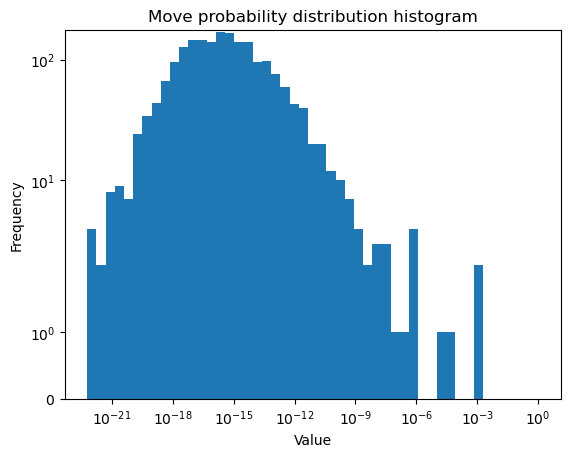

In [71]:
import matplotlib.pyplot as plt
board=chess.Board()
board.set_fen('7k/8/8/8/8/8/8/K7 w - - 0 1')
x=board_to_network_input(board)
y=model(np.expand_dims(x, axis=0))
y=np.array(y)[0]
print(y)


# Create logarithmic bins
logbins = np.logspace(np.log10(y.min()),np.log10(y.max()), 50)

# Plot the histogram
plt.hist(y, bins=logbins)

# Set the axis scale to logarithmic
plt.xscale('log')
plt.yscale('symlog')
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Move probability distribution histogram')

# Display the plot
plt.show()

In [67]:
# print('hi')
# Get the indices of the sorted array in descending order
sorted_indices = np.argsort(y)[::-1]
n=50
# Print the top n values
top_n_moves=possible_moves[sorted_indices][:n]
leg_moves=[str(move) for move in list(board.legal_moves)]

print('we have', len(leg_moves), 'legal moves')
# print(leg_moves)
i=0
for j,element in enumerate(top_n_moves):
    if element in leg_moves:
        print(j+1,"th element ",element, 'is a legal move. total counted:',i)
        i+=1

        
print('by trying the first ',n,' recommendations of the network we achieved'\
     , 100*i/len(leg_moves),'% legal moves coverage')
print(top_n_moves)

we have 3 legal moves
1 th element  a1b2 is a legal move. total counted: 0
2 th element  a1b1 is a legal move. total counted: 1
3 th element  a1a2 is a legal move. total counted: 2
by trying the first  50  recommendations of the network we achieved 100.0 % legal moves coverage
['a1b2' 'a1b1' 'a1a2' 'a1c3' 'a1d1' 'a1d4' 'a1c1' 'c1b2' 'a1e5' 'a1a4'
 'a3b2' 'a1a7' 'b1b2' 'a2b2' 'a1f6' 'a1g7' 'a3a4' 'c3b2' 'a1h1' 'f6b2'
 'c2b2' 'e2b2' 'a1a3' 'a1f1' 'a1a6' 'g4g5' 'a1a5' 'h7h8r' 'h1b1' 'b1c1'
 'h4h5' 'a1h8' 'd7a7' 'g1g2' 'e6e7' 'h8b2' 'a1g1' 'b3b2' 'g2f1' 'b6b2'
 'a1a8' 'a3a2' 'b6b7' 'h7h8q' 'f2d1' 'f5f4' 'e2a2' 'b8b2' 'e5b2' 'b1a2']
